In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np
import os
import trimesh
import b3d
from jax.scipy.spatial.transform import Rotation as Rot
from b3d import Pose
#from b3d.utils import unproject_depth
import rerun as rr
import genjax
from tqdm import tqdm


rr.init("demo.py")
rr.connect("127.0.0.1:8812")
#rr.save('single_box')


In [2]:
width=128
height=128
fx=64.0
fy=64.0
cx=64.0
cy=64.0
near=0.001
far=16.0
renderer = b3d.Renderer(
    width, height, fx, fy, cx, cy, near, far
)

In [3]:
def rotation_from_axis_angle(axis, angle):
    """Creates a rotation matrix from an axis and angle.

    Args:
        axis (jnp.ndarray): The axis vector. Shape (3,)
        angle (float): The angle in radians.
    Returns:
        jnp.ndarray: The rotation matrix. Shape (3, 3)
    """
    sina = jnp.sin(angle)
    cosa = jnp.cos(angle)
    direction = axis / jnp.linalg.norm(axis)
    # rotation matrix around unit vector
    R = jnp.diag(jnp.array([cosa, cosa, cosa]))
    R = R + jnp.outer(direction, direction) * (1.0 - cosa)
    direction = direction * sina
    R = R + jnp.array(
        [
            [0.0, -direction[2], direction[1]],
            [direction[2], 0.0, -direction[0]],
            [-direction[1], direction[0], 0.0],
        ]
    )
    return R

def transform_from_rot(rotation):
    """Creates a pose matrix from a rotation matrix.

    Args:
        rotation (jnp.ndarray): The rotation matrix. Shape (3, 3)
    Returns:
        jnp.ndarray: The pose matrix. Shape (4, 4)
    """
    return jnp.vstack(
        [jnp.hstack([rotation, jnp.zeros((3, 1))]), jnp.array([0.0, 0.0, 0.0, 1.0])]
    )

def transform_from_axis_angle(axis, angle):
    """Creates a pose matrix from an axis and angle.

    Args:
        axis (jnp.ndarray): The axis vector. Shape (3,)
        angle (float): The angle in radians.
    Returns:
        jnp.ndarray: The pose matrix. Shape (4, 4)
    """
    return transform_from_rot(rotation_from_axis_angle(axis, angle))



In [4]:
r_mat = transform_from_axis_angle(jnp.array([0,0,1]), jnp.pi/2)

In [5]:

vec_transform_axis_angle = jax.vmap(transform_from_axis_angle, (None, 0))
rots = vec_transform_axis_angle(jnp.array([0,0,1]), jnp.linspace(0, 3*jnp.pi/4, 30))

In [6]:
mesh_path = os.path.join(b3d.get_root_path(),
    "assets/shared_data_bucket/ycb_video_models/models/003_cracker_box/textured_simple.obj")
mesh = trimesh.load(mesh_path)

object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_trimesh(mesh)

cam_inv_pose = b3d.Pose.from_position_and_target(
    jnp.array([0.15, 0.15, 0.0]),
    jnp.array([0.0, 0.0, 0.0])
).inv()


in_place_rots = b3d.Pose.from_matrix(rots)


compound_pose = cam_inv_pose @ in_place_rots #in_place_rot



rgbs, depths = renderer.render_attribute_many(
    compound_pose[:,None,...],
    object_library.vertices,
    object_library.faces,
    jnp.array([[0, len(object_library.faces)]]),
    object_library.attributes
)
#b3d.get_rgb_pil_image(rgb).save(b3d.get_root_path() / "assets/test_ycb.png")

In [7]:
class Intrinsics:
    width=128
    height=128
    fx=64.0
    fy=64.0
    cx=64.0
    cy=64.0
    near=0.001
    far=16.0

intrinsics = Intrinsics()

def unproject_depth(depth, intrinsics):
    """Unprojects a depth image into a point cloud.

    Args:
        depth (jnp.ndarray): The depth image. Shape (H, W)
        intrinsics (b.camera.Intrinsics): The camera intrinsics.
    Returns:
        jnp.ndarray: The point cloud. Shape (H, W, 3)
    """
    mask = (depth < intrinsics.far) * (depth > intrinsics.near)
    depth = depth * mask + intrinsics.far * (1.0 - mask)
    y, x = jnp.mgrid[: depth.shape[0], : depth.shape[1]]
    x = (x - intrinsics.cx) / intrinsics.fx
    y = (y - intrinsics.cy) / intrinsics.fy
    point_cloud_image = jnp.stack([x, y, jnp.ones_like(x)], axis=-1) * depth[:, :, None]
    return point_cloud_image

In [8]:
unproject_depth_vec = jax.vmap(unproject_depth, (0, None))

In [9]:
xyzs = unproject_depth_vec(depths, intrinsics)

In [10]:
from b3d import Pose

num_layers = 2048
renderer = b3d.Renderer(width, height, fx, fy, cx, cy, near, far, num_layers)
model = b3d.model_multiobject_gl_factory(renderer)
importance_jit = jax.jit(model.importance)
update_jit = jax.jit(model.update)

# Arguments of the generative model.
# These control the inlier / outlier decision boundary for color error and depth error.
#color_error, depth_error = (jnp.float32(10.0), jnp.float32(0.001))
color_error, depth_error = (jnp.float32(50.0), jnp.float32(0.02))
# TODO: explain
inlier_score, outlier_prob = (jnp.float32(50.0), jnp.float32(0.001))
# TODO: explain
color_multiplier, depth_multiplier = (jnp.float32(3000.0), jnp.float32(3000.0))


# Defines the enumeration schedule.
key = jax.random.PRNGKey(0)
# Gridding on translation only.
translation_deltas = Pose.concatenate_poses([jax.vmap(lambda p: Pose.from_translation(p))(jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-0.01, 0.01, 11),
        jnp.linspace(-0.01, 0.01, 11),
        jnp.linspace(-0.01, 0.01, 11),
    ),
    axis=-1,
).reshape(-1, 3)), Pose.identity()[None,...]])
# Sample orientations from a VMF to define a "grid" over orientations.

#tighter grid centered at current orientation

rotation_deltas = Pose.concatenate_poses([jax.vmap(Pose.sample_gaussian_vmf_pose, in_axes=(0,None, None, None))(
    jax.random.split(jax.random.PRNGKey(0), 11*11*11),
    Pose.identity(),
    0.00001, 1000.0
    #0.01, 1000.0
), Pose.identity()[None,...]])
all_deltas =  Pose.stack_poses([translation_deltas, rotation_deltas])

In [11]:
# Make empty library
object_library = b3d.MeshLibrary.make_empty_library()

In [12]:
x_center = 64
y_center = 64 
del_pix = 5 

local_points = xyzs[0,x_center-del_pix:x_center+del_pix,y_center-del_pix:y_center+del_pix,:].reshape(-1,3)
local_rgbs = rgbs[0,x_center-del_pix:x_center+del_pix,y_center-del_pix:y_center+del_pix,:].reshape(-1,3)
patch_center = xyzs[0,x_center,y_center,:]

point_cloud = local_points
point_cloud_colors = local_rgbs

In [13]:
# Create new mesh.
vertices, faces, vertex_colors, face_colors = b3d.make_mesh_from_point_cloud_and_resolution(
    point_cloud, point_cloud_colors, point_cloud[:,2] / fx * 2.0
)
object_pose = Pose.from_translation(vertices.mean(0))
vertices = object_pose.inverse().apply(vertices)
object_library.add_object(vertices, faces, vertex_colors)


In [14]:

model_args = b3d.model.ModelArgs(color_error, depth_error,
                            inlier_score, outlier_prob,
                            color_multiplier, depth_multiplier)

trace, _ = importance_jit(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        dict([
            ("camera_pose", Pose.identity()),
            ("object_pose_0", object_pose),
            ("object_0", 0),
            ("observed_rgb_depth", (rgbs[0], xyzs[0,...,2])),
        ])
    ),
    (jnp.arange(1),model_args, object_library)
)

# Visualize trace
#b3d.rerun_visualize_trace_t(trace, 0)

FINAL_T = len(xyzs)
scores = []
for T_observed_image in tqdm(range(0, FINAL_T)):
    # Constrain on new RGB and Depth data.
    trace = b3d.update_choices_jit(trace, key,
        genjax.Pytree.const(["observed_rgb_depth"]),
        (rgbs[T_observed_image],xyzs[T_observed_image,...,2])
    )
    trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const(["camera_pose"]), key, all_deltas)
    trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const([f"object_pose_0"]), key, all_deltas)

    score = trace.get_score()
    scores.append(score)
    #b3d.rerun_visualize_trace_t(trace, T_observed_image)

    (observed_rgb, rendered_rgb), (observed_depth, rendered_depth) = trace.get_retval()
    rr.set_time_sequence("frame", T_observed_image)
    rr.log("/vmf_tracking", rr.Image(observed_rgb))
    rr.log("/vmf_tracking/rgb_rendering", rr.Image(rendered_rgb))
    rr.log('/vmf_score', rr.TimeSeriesScalar(score))

    (inliers, color_inliers, depth_inliers, valid_data_mask) = b3d.get_rgb_depth_inliers_from_trace(trace)
    rr.log("/vmf_tracking/color_inliers", rr.DepthImage(color_inliers * 1.0))

  0%|          | 0/30 [00:00<?, ?it/s]/var/tmp/ipykernel_384548/2793158847.py:40: DeprecationWarning: Use the `Scalar` + (optional) `SeriesLine`/`SeriesPoint` archetypes instead, logged on the same entity. See [0.13 migration guide](https://www.rerun.io/docs/reference/migration/migration-0-13).
  rr.log('/vmf_score', rr.TimeSeriesScalar(score))
100%|██████████| 30/30 [00:16<00:00,  1.79it/s]


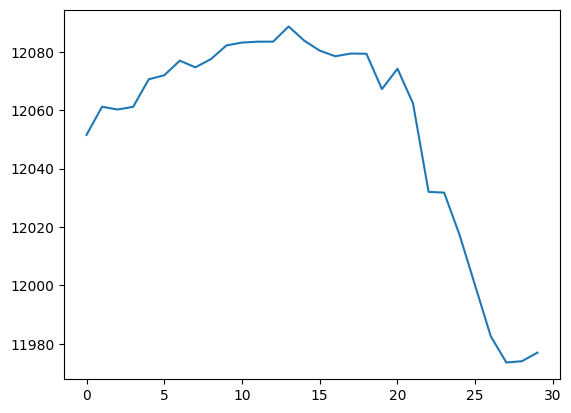

In [15]:
plt.plot(scores)

In [16]:
vertices, faces, vertex_colors, face_colors = b3d.make_mesh_from_point_cloud_and_resolution(
    point_cloud, point_cloud_colors, point_cloud[:,2] / fx * 2.0
)
object_pose = Pose.identity()
vertices = object_pose.inverse().apply(vertices)
object_library.add_object(vertices, faces, vertex_colors)


In [17]:
model_args = b3d.model.ModelArgs(color_error, depth_error,
                            inlier_score, outlier_prob,
                            color_multiplier, depth_multiplier)

trace, _ = importance_jit(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        dict([
            ("camera_pose", Pose.identity()),
            ("object_pose_0", Pose.identity()),
            ("object_0", 1),
            ("observed_rgb_depth", (rgbs[0], xyzs[0,...,2])),
        ])
    ),
    (jnp.arange(2),model_args, object_library)
)

# Visualize trace
#b3d.rerun_visualize_trace_t(trace, 0)


FINAL_T = len(xyzs)
scores = []
for T_observed_image in tqdm(range(FINAL_T)):
    # Constrain on new RGB and Depth data.
    trace = b3d.update_choices_jit(trace, key,
        genjax.Pytree.const(["observed_rgb_depth"]),
        (rgbs[T_observed_image],xyzs[T_observed_image,...,2])
    )
    #trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const(["camera_pose"]), key, all_deltas)
    #trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const([f"object_pose_0"]), key, all_deltas)

    #in_place_rots[T_observed_image] @ in_place_rots[T_observed_image-1].inv() @ 

    update_pose = cam_inv_pose @ in_place_rots[T_observed_image] @ cam_inv_pose.inv()

    trace = b3d.update_choices_jit(trace, key, genjax.Pytree.const([f"object_pose_0"]), update_pose)
    score = trace.get_score()
    scores.append(score)
    #b3d.rerun_visualize_trace_t(trace, T_observed_image)
    
    (observed_rgb, rendered_rgb), (observed_depth, rendered_depth) = trace.get_retval()
    rr.set_time_sequence("frame", T_observed_image)
    rr.log("/gt_tracking", rr.Image(observed_rgb))
    rr.log("/gt_tracking/rgb_rendering", rr.Image(rendered_rgb))
    rr.log('/gt_score', rr.TimeSeriesScalar(score))

    (inliers, color_inliers, depth_inliers, valid_data_mask) = b3d.get_rgb_depth_inliers_from_trace(trace)
    rr.log("/gt_tracking/color_inliers", rr.DepthImage(color_inliers * 1.0))

  0%|          | 0/30 [00:00<?, ?it/s]/var/tmp/ipykernel_384548/1399644787.py:46: DeprecationWarning: Use the `Scalar` + (optional) `SeriesLine`/`SeriesPoint` archetypes instead, logged on the same entity. See [0.13 migration guide](https://www.rerun.io/docs/reference/migration/migration-0-13).
  rr.log('/gt_score', rr.TimeSeriesScalar(score))
100%|██████████| 30/30 [00:06<00:00,  4.80it/s]


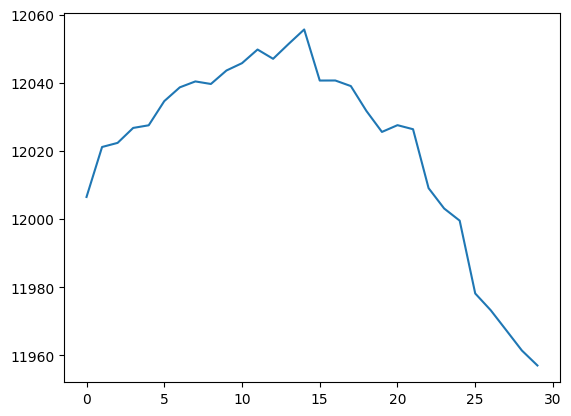

In [18]:
plt.plot(scores)

In [19]:
scores

[Array(12006.466, dtype=float32),
 Array(12021.129, dtype=float32),
 Array(12022.336, dtype=float32),
 Array(12026.722, dtype=float32),
 Array(12027.497, dtype=float32),
 Array(12034.581, dtype=float32),
 Array(12038.632, dtype=float32),
 Array(12040.367, dtype=float32),
 Array(12039.618, dtype=float32),
 Array(12043.571, dtype=float32),
 Array(12045.722, dtype=float32),
 Array(12049.728, dtype=float32),
 Array(12047.004, dtype=float32),
 Array(12051.377, dtype=float32),
 Array(12055.609, dtype=float32),
 Array(12040.626, dtype=float32),
 Array(12040.641, dtype=float32),
 Array(12039.003, dtype=float32),
 Array(12031.71, dtype=float32),
 Array(12025.55, dtype=float32),
 Array(12027.531, dtype=float32),
 Array(12026.344, dtype=float32),
 Array(12009.054, dtype=float32),
 Array(12003.088, dtype=float32),
 Array(11999.518, dtype=float32),
 Array(11978.148, dtype=float32),
 Array(11973.211, dtype=float32),
 Array(11967.33, dtype=float32),
 Array(11961.417, dtype=float32),
 Array(11957.022,

In [20]:
## numerical stability issues, per peaked plot above
## TODO: fix numerical instability

In [21]:
#show cloud

In [22]:
# rr.log('frag', rr.Points3D(unproject_depth(rendered_depth, intrinsics).reshape(-1,3), colors=rendered_rgb.reshape(-1,3)))
# rr.log('full', rr.Points3D(unproject_depth(observed_depth, intrinsics).reshape(-1,3), colors=observed_rgb.reshape(-1,3)))


In [23]:
## write new renderer that natively outputs surface normal